# Аттестация 2 + Домашнее задание № 3

Порядок действий.

1. Предобработка.
2. Анализ данных:
- Выполните первичный анализ данных: статистические характеристики, распределение признаков, корреляционный анализ.
- Постройте визуализации для лучшего понимания структуры данных.
3. Построение модели логистической регрессии:
- Постройте модель логистической регрессии для бинарной классификации.
- Оцените качество модели с использованием метрик точности (accuracy), полноты (recall), точности (precision) и F1-меры.
- Постройте ROC-кривую и вычислите AUC.
4. Построение модели дерева решений, оценка качества модели с использованием соответствующих метрик.
5. Построение модели случайного леса, оценка качества модели с использованием соответствующих метрик.
6. Сравнение результатов всех построенных моделей.

Обсуждение преимуществ и недостатков каждой модели, а также их применимость к данному набору данных.

In [2]:
import time
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from numpy import mean
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

data_1 = sns.load_dataset("titanic")  # Загружаем датасет

# Заполним пропуски в столбце "age" медианными значениями и сохраним данные в новом столбце "age_median"
data_1['age_median'] = data_1['age'].fillna(data_1['age'].median())

'''Исключаем из работы часть столбцов.
Столбец "embarked" содержит первую букву из названия городов с портами, где сели пассажиры. Эти же данные уже есть
в столбце "embark_town".
Столбец "class" содержит категориальные данные, которые по сути, дублируются в столбеце "pclass", в уже нужном нам виде.
Столбец "deck" ("палуба") исключаем, т.к. отсутствует большая часть данных и заполнить пробелы каким-либо способом
не возможно.
Столбец "alive", т.к. он по сути дублирует столбец "survived"'''

data_1.drop(['age', 'embarked', 'class', 'deck', 'alive'], axis = 1 , inplace = True)

# Заполняем две пустые ячейки в столбце "embark_town", значениями с предыдущих строк
data_1['embark_town'] = data_1['embark_town'].ffill()

In [3]:
start_1 = time.time()  # Засекаем время работы кода

# Переводим все объектные данные в дамми-переменные
new_df = pd.get_dummies(data_1, columns = ['sex', 'who', 'embark_town'])

# Масштабирование числовых признаков
scaler = StandardScaler()
new_df[['pclass', 'sibsp', 'parch', 'fare', 'age_median']] = scaler.fit_transform(new_df[['pclass', 'sibsp', 'parch', 'fare', 'age_median']])
# new_df[['fare', 'age_median']] = scaler.fit_transform(new_df[['fare', 'age_median']])  # Можно и менее глобально масштабировать, но от этого скоры становятся чуть меньше

# Отделение признаков от целевой переменной
X = new_df.drop(columns = ['survived'])
y = new_df['survived']

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Обучение модели логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Оценка модели
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

finish_1 = time.time()  # Останавливаем таймер и считаем время
res_1 = finish_1 - start_1

print('Время работы в секундах:', res_1)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'ROC AUC: {roc_auc}')

Время работы в секундах: 0.04188871383666992
Accuracy: 0.8171641791044776
Precision: 0.803921568627451
Recall: 0.7387387387387387
F1 Score: 0.7699530516431925
ROC AUC: 0.8830550295518448


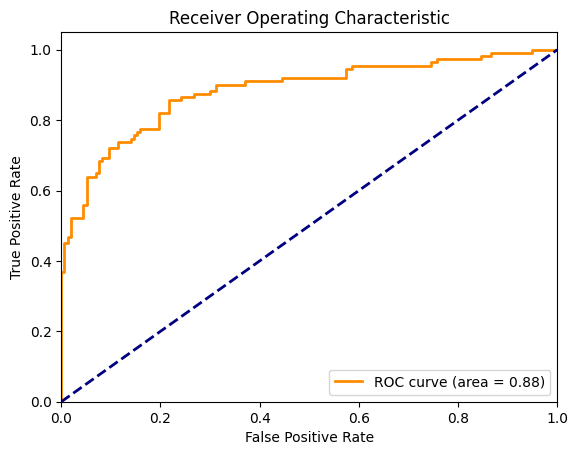

In [4]:
# Построение ROC-кривой

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = "lower right")
plt.show()

In [5]:
# 4. Построение модели дерева решений, оценка качества модели с использованием соответствующих метрик.

start_2 = time.time()  # Засекаем время работы кода

# Переводим все объектные данные в дамми-переменные
new_df_decision_tree_class = pd.get_dummies(data_1, columns = ['sex', 'who', 'embark_town'], drop_first = True)

# Разделение данных на признаки и целевую переменную
X = new_df_decision_tree_class.drop(columns = ['survived'])
y = new_df_decision_tree_class['survived']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Создание и обучение модели дерева решений
dt_clf = DecisionTreeClassifier(max_depth = 4, max_features = 5, random_state = 42)
dt_clf.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = dt_clf.predict(X_test)

# Оценка модели на тестовой выборке
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

# Кросс-валидация
scores = cross_val_score(dt_clf, X, y, cv = 5)
print(f'Mean cross-validation score: {scores.mean()}')

finish_2 = time.time()  # Останавливаем таймер и считаем время
res_2 = finish_2 - start_2
print('Время работы в секундах:', res_2)

Accuracy: 0.832089552238806
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       157
           1       0.82      0.77      0.79       111

    accuracy                           0.83       268
   macro avg       0.83      0.82      0.83       268
weighted avg       0.83      0.83      0.83       268

Mean cross-validation score: 0.8103508882053857
Время работы в секундах: 0.04089045524597168


In [6]:
# 5. Построение модели случайного леса, оценка качества модели с использованием соответствующих метрик.

start_3 = time.time()  # Засекаем время работы кода

# Переводим все объектные данные в дамми-переменные
new_df_random_forest_class = pd.get_dummies(data_1, columns = ['sex', 'who', 'embark_town'], drop_first = True)

# Разделение данных на признаки и целевую переменную
X = new_df_decision_tree_class.drop(columns = ['survived'])
y = new_df_decision_tree_class['survived']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Создание и обучение модели дерева решений
rf_clf = RandomForestClassifier(n_estimators = 50, max_depth = 7, max_features = 8, min_samples_leaf = 2, random_state = 42)

# Определение значений 'max_depth' и 'max_features'
# rf_clf_params = {'max_depth': range(2, 10), 'max_features': range(3, 10)}
# forest_grid = GridSearchCV(rf_clf, rf_clf_params, cv = 3, n_jobs = -1, verbose = True)
# forest_grid.fit(X_train, y_train)
# forest_grid.best_params_, forest_grid.best_score_ # ({'max_depth': 7, 'max_features': 8}, 0.8394)

rf_clf.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = rf_clf.predict(X_test)

# Оценка модели на тестовой выборке
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

# Кросс-валидация
scores = cross_val_score(rf_clf, X, y, cv = 10)
print(f'Mean cross-validation score: {scores.mean()}')

finish_3 = time.time()  # Останавливаем таймер и считаем время
res_3 = (finish_3 - start_3)
print('Время работы в секундах:', res_3)

Accuracy: 0.8324022346368715
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       105
           1       0.84      0.73      0.78        74

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

Mean cross-validation score: 0.8395505617977529
Время работы в секундах: 1.2601406574249268


И так, подведём результаты основываясь на метрику Accuracy:

LogisticRegression - 0.8171
DecisionTreeClassifier - 0.8320
RandomForestClassifier - 0.8324

В данном случает, RandomForest показал наилучший результат, как в точности, так и Mean cross-validation, где отрыв от RandomForest более значительный - 0.8395 против 0.8103.
Но, время работы RandomForest ощутимо дольше - 1.06 сек против 0.04 сек у DecisionTree. Время работы LogisticRegression примерно одинаковое с DecisionTree, но точность меньше.

Можно сделать RandomForest быстрее, например, уменьшив параметр кросс-валидации до 3, тем самым сократив время работы до 4 сек, но потеряв в Mean cross-validation score. Выбор зависит от цели и ресурсов машины - требуются более высокие скоры или меньшие временные затраты на выполнение кода.

In [27]:
# Переводим все объектные данные в дамми-переменные
new_df_cat_boost_class = pd.get_dummies(data_1, columns = ['sex', 'who', 'embark_town'], drop_first = True)

# Разделение данных на признаки и целевую переменную
X = new_df_cat_boost_class.drop(columns = ['survived'])
y = new_df_cat_boost_class['survived']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Обучение модели CatBoost и вывод метрик

models = {'CatBoost': CatBoostClassifier(verbose = 0, max_depth = 7, learning_rate = 0.01, n_estimators = 100)}

metrics = []

for model_name, model in models.items():
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    metrics.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    })

metrics_df = pd.DataFrame(metrics)
metrics_df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,CatBoost,0.815642,0.80597,0.72973,0.765957,0.884685


In [29]:
# Оценка точности модели CatBoost, с применением метода RepeatedStratifiedKFold (результат стал лучше)

model = CatBoostClassifier(verbose = 0, n_estimators = 50)
cv = RepeatedStratifiedKFold(n_splits = 7, n_repeats = 4, random_state = 1)
n_scores = cross_val_score(model, X, y, scoring = 'accuracy', cv = cv)
print('Accuracy: %.6f' % (mean(n_scores)))

Accuracy: 0.827180


In [13]:
# Оценка метрик модели XGBoost с подбором гиперпараметров

param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.001, 1],
    'max_depth': [3, 7]
}

test_model = XGBClassifier()
grid_search = GridSearchCV(estimator = test_model, param_grid = param_grid, cv = 3, scoring = 'accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# Обучение модели с лучшими параметрами
test_model.set_params(**best_params)
test_model.fit(X, y)

metrics = []
y_pred = test_model.predict(X_test)
y_pred_proba = test_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

metrics.append({
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC AUC': roc_auc
})

pd.DataFrame(metrics)

Best Parameters: {'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 500}


,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,0.854749,0.913793,0.716216,0.80303,0.925869


Модель XGBoost с подбором гиперпараметров показала наилучший результат, в сравнении с CatBoost с указании параметров пользователем.